In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, MeanShift, Birch

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from scipy.spatial import ConvexHull

from utils import confidence_ellipse

In [2]:
PALETTE = 'bright'

sns.set_theme(
    context='paper',
    style='whitegrid',
    palette=PALETTE,
    font='Trebuchet MS',
)
sns.despine()

<Figure size 640x480 with 0 Axes>

In [3]:
ds = pd.read_csv("polls_us_elections_2016.csv")

In [29]:
# Convert dates to datetime format for proper time-series handling
ds['startdate'] = pd.to_datetime(ds['startdate'])
ds['enddate'] = pd.to_datetime(ds['enddate'])

# Filter relevant columns
# poll_data = ds[['pollster', 'startdate', 'enddate', 'grade', 'adjpoll_clinton', 'adjpoll_trump', 'adjpoll_johnson', 'adjpoll_mcmullin']].dropna()
poll_data = ds[['pollster', 'startdate', 'enddate', 'grade', 'adjpoll_clinton', 'adjpoll_trump']].dropna()

# Melt the data to have candidates in one column
poll_data_melted = poll_data.melt(id_vars=['startdate', 'enddate', 'pollster', 'grade'], 
                                  value_vars=['adjpoll_clinton', 'adjpoll_trump'],
                                #   value_vars=['adjpoll_clinton', 'adjpoll_trump', 'adjpoll_johnson', 'adjpoll_mcmullin'],
                                  var_name='candidate', 
                                  value_name='adjusted_poll')

# Replace candidate names for readability
poll_data_melted['candidate'] = poll_data_melted['candidate'].replace({
    'adjpoll_clinton': 'Clinton', 
    'adjpoll_trump': 'Trump', 
    # 'adjpoll_johnson': 'Johnson', 
    # 'adjpoll_mcmullin': 'McMullin'
})

In [30]:
poll_data.size

22674

In [6]:
poll_data_melted

,startdate,enddate,pollster,grade,candidate,adjusted_poll
0,2016-11-03,2016-11-06,ABC News/Washington Post,A+,Clinton,45.20163
1,2016-11-01,2016-11-07,Google Consumer Surveys,B,Clinton,43.34557
2,2016-11-02,2016-11-06,Ipsos,A-,Clinton,42.02638
3,2016-11-04,2016-11-07,YouGov,B,Clinton,45.65676
4,2016-11-03,2016-11-06,Gravis Marketing,B-,Clinton,46.84089
...,...,...,...,...,...,...
7553,2016-09-16,2016-09-22,Ipsos,A-,Trump,40.48017
7554,2016-08-04,2016-08-07,Marquette University,A,Trump,39.07778
7555,2016-11-01,2016-11-07,Google Consumer Surveys,B,Trump,40.57738
7556,2016-10-21,2016-11-02,Ipsos,A-,Trump,37.10720


# Categories of Pollsters

There are several states which does not have a *Winner-Takes-All* system: Maine and Nebraska. These states split their votes in some cases.

It would be more reasonable to keep consistency and first analyse all the other states.

## A-Grade

In [7]:
# Filter the dataset for pollsters that have an 'A' grade (A+, A, A-)
ds_states = ds[ds['state'] != 'U.S.']
ds_states = ds_states[~ds_states['state'].isin(['Nebraska', 'Maine CD-1', 'Maine CD-2'])]
a_grade_pollsters = ds_states[ds_states['grade'].isin(['A+', 'A', 'A-'])]

# Group by pollster and state to get the count of polls conducted
a_pollster_state_count = a_grade_pollsters.groupby(['pollster', 'state']).size().reset_index(name='poll_count')

# Get unique A-grade pollsters
unique_pollsters = a_grade_pollsters['pollster'].unique()

a_pollster_state_count

,pollster,state,poll_count
0,ABC News/Washington Post,Maryland,2
1,ABC News/Washington Post,Virginia,2
2,Behavior Research Center (Rocky Mountain),Arizona,1
3,CNN/Opinion Research Corp.,Arizona,2
4,CNN/Opinion Research Corp.,Colorado,1
...,...,...,...
142,SurveyUSA,Utah,1
143,SurveyUSA,Washington,1
144,Time/Abt SRBI,Georgia,3
145,University of Arkansas,Arkansas,1


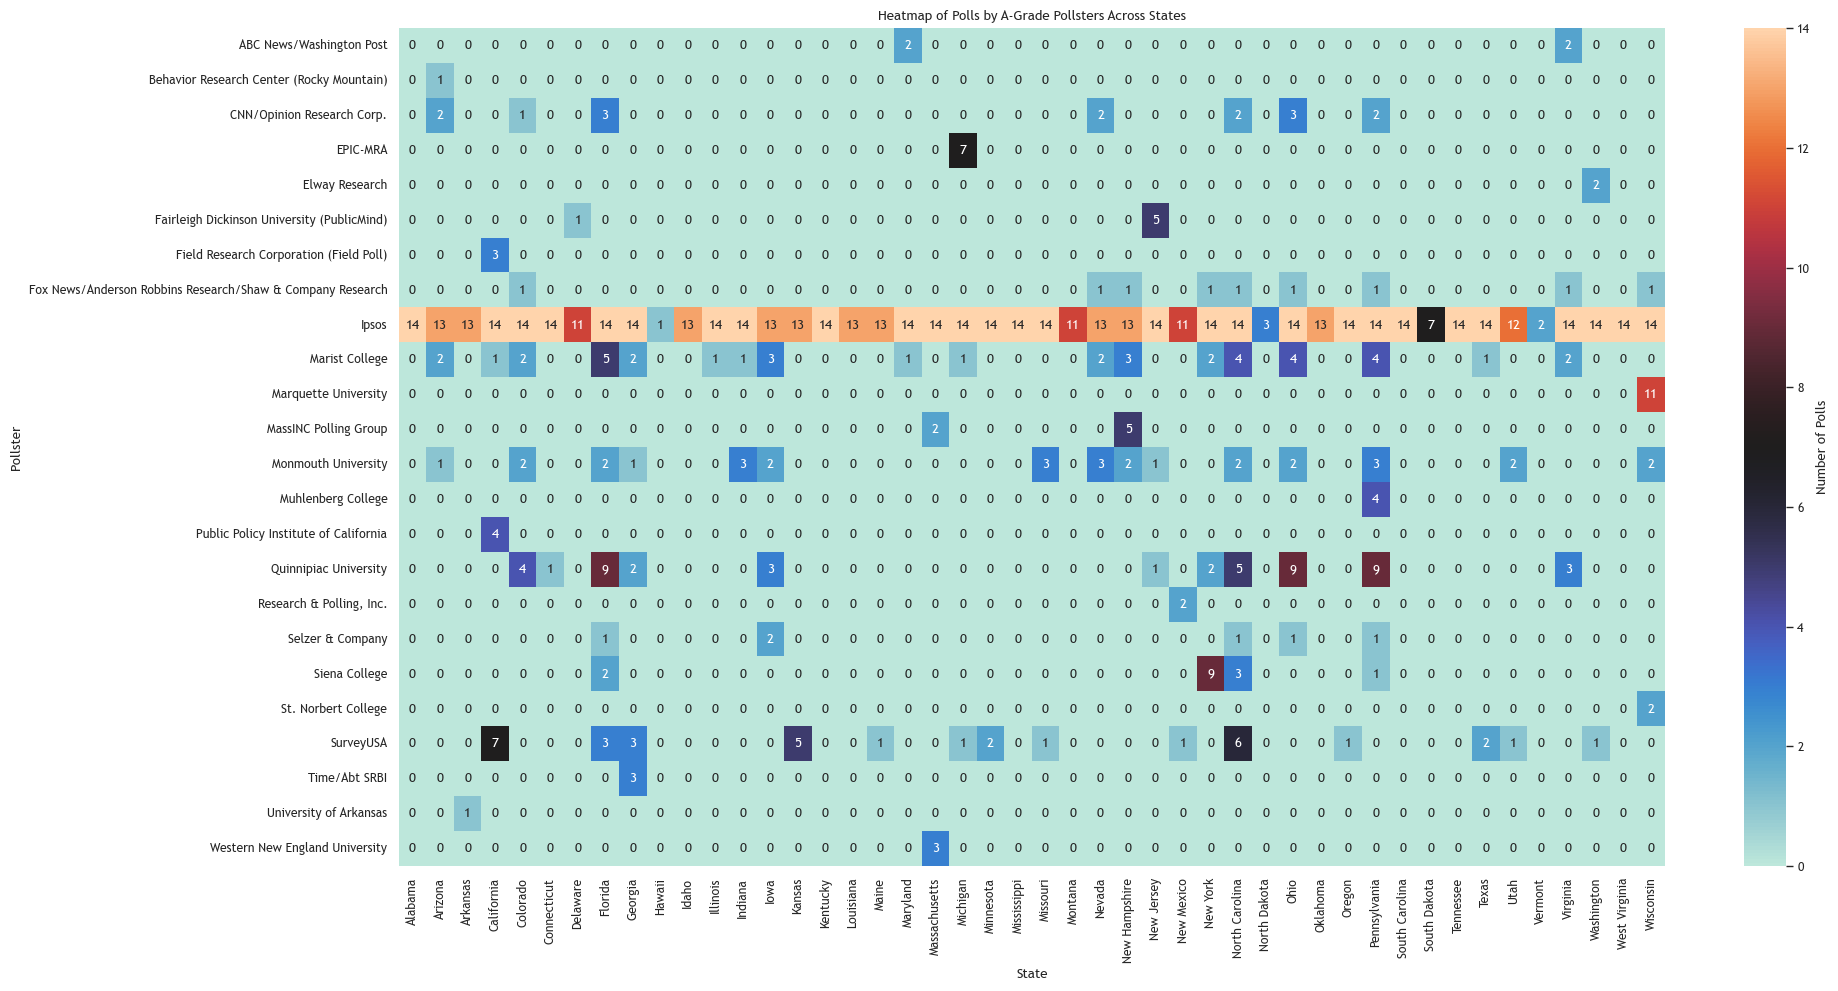

In [8]:
# Pivot the data to create a matrix with pollsters as rows and states as columns
pollster_state_pivot = a_pollster_state_count.pivot(index='pollster', columns='state', values='poll_count').fillna(0)

# Create the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(pollster_state_pivot, cmap='icefire', annot=True, fmt='g', cbar_kws={'label': 'Number of Polls'})

plt.title('Heatmap of Polls by A-Grade Pollsters Across States')
plt.xlabel('State')
plt.ylabel('Pollster')
plt.tight_layout()

plt.show()

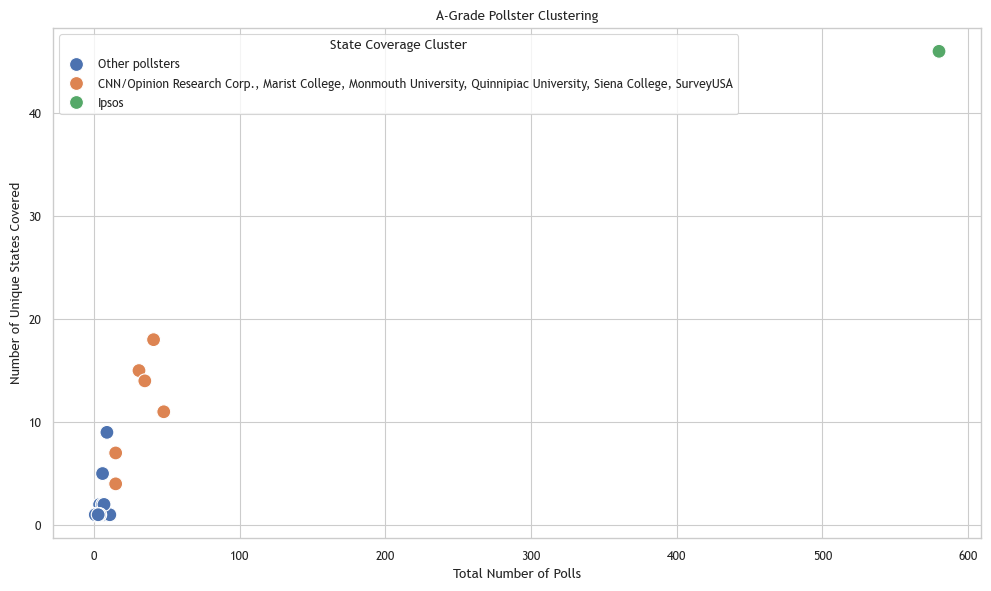

In [9]:
# Calculate the total number of polls and the number of unique states for each pollster
a_pollster_stats = a_pollster_state_count.groupby('pollster').agg(
    total_polls=('poll_count', 'sum'),
    unique_states=('state', 'nunique')
).reset_index()

# Pivot the data to create a matrix with pollsters as rows and states as columns
a_pollster_state_pivot = a_pollster_state_count.pivot(index='pollster', columns='state', values='poll_count').fillna(0)

# Apply clustering
n_clusters = 3
cl = Birch(threshold=1.785, n_clusters=n_clusters)
a_pollster_state_pivot['cluster'] = cl.fit_predict(a_pollster_state_pivot)

# Add cluster labels to the pollster stats dataframe
a_pollster_stats['cluster'] = a_pollster_state_pivot['cluster'].values

# Instead of numbers let's put some names of the clusters
a_cluster_counts = a_pollster_state_pivot['cluster'].value_counts().sort_values()
a_cluster_sorted = a_cluster_counts.index.to_list()

a_pollster_stats['cluster_name'] = 'Other pollsters'

a_pollsters_cluster_1 = a_pollster_stats[a_pollster_stats['cluster'] == a_cluster_sorted[0]]['pollster']
a_pollsters_cluster_1_name = ', '.join(a_pollsters_cluster_1.values)
a_pollster_stats.loc[a_pollster_stats['cluster'] == a_cluster_sorted[0], 'cluster_name'] = a_pollsters_cluster_1_name

a_pollsters_cluster_2 = a_pollster_stats[a_pollster_stats['cluster'] == a_cluster_sorted[1]]['pollster']
a_pollsters_cluster_2_name = ', '.join(a_pollsters_cluster_2.values)
a_pollster_stats.loc[a_pollster_stats['cluster'] == a_cluster_sorted[1], 'cluster_name'] = a_pollsters_cluster_2_name


# Recreate the scatter plot focusing only on state coverage clusters and total polls
plt.figure(figsize=(10, 6))
sns.scatterplot(data=a_pollster_stats, x='total_polls', y='unique_states', hue='cluster_name', palette='deep', s=100)

plt.title('A-Grade Pollster Clustering')
plt.xlabel('Total Number of Polls')
plt.ylabel('Number of Unique States Covered')
plt.legend(title='State Coverage Cluster')
plt.tight_layout()

plt.show()

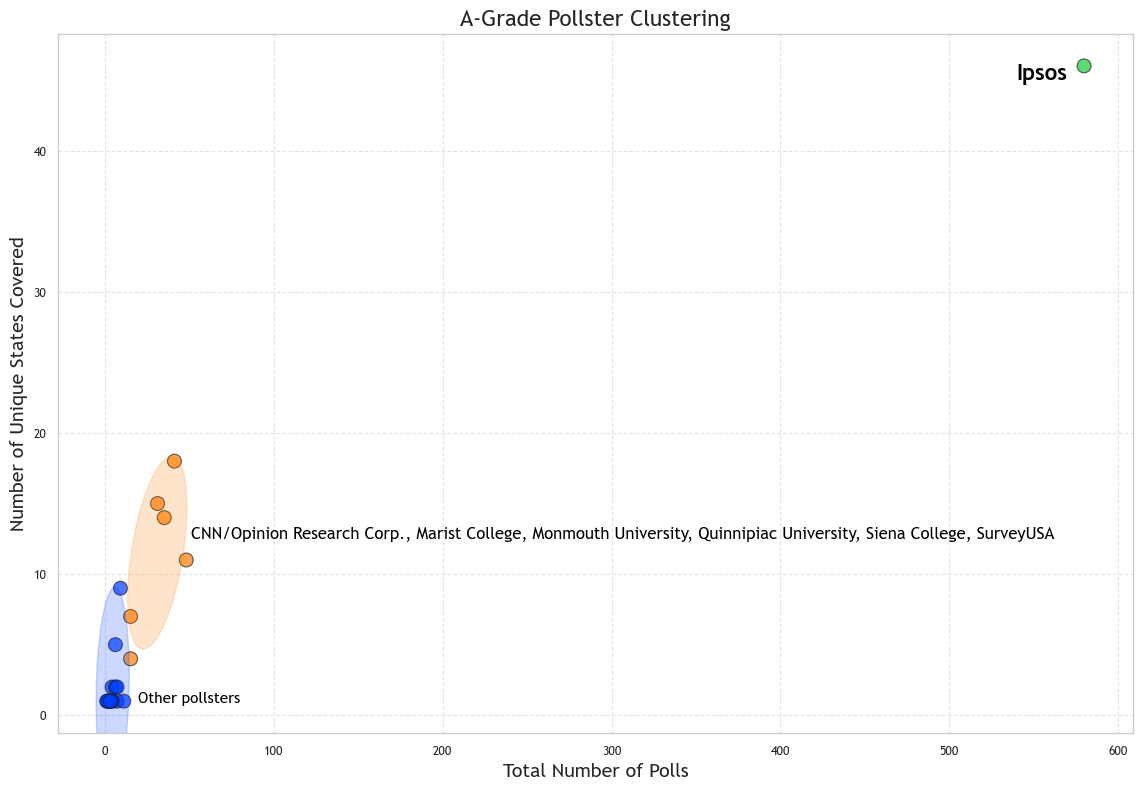

In [10]:
unique_cluster_names = a_pollster_stats['cluster_name'].unique()
palette = sns.color_palette(PALETTE, len(unique_cluster_names))

# Map each cluster name to a color
color_mapping = dict(zip(unique_cluster_names, palette))

plt.figure(figsize=(12, 8))
ax = plt.gca()

sns.scatterplot(
    data=a_pollster_stats,
    x='total_polls',
    y='unique_states',
    hue='cluster_name',
    palette=color_mapping,
    s=100,
    edgecolor='k',
    alpha=0.7
)

plt.legend().remove()

# Calculate centroids for each cluster
centroids = a_pollster_stats.groupby('cluster_name')[['total_polls', 'unique_states']].mean().reset_index()

# Annotate each cluster with its name
plt.text(
    centroids.iloc[0]['total_polls'] + 20,
    centroids.iloc[0]['unique_states'] + 1,
    centroids.iloc[0]['cluster_name'],
    fontsize=12,
    fontweight='400',
    horizontalalignment='left',
    color='black',
)
plt.text(
    centroids.iloc[1]['total_polls'] - 10,
    centroids.iloc[1]['unique_states'] - 1,
    centroids.iloc[1]['cluster_name'],
    fontsize=16,
    fontweight='bold',
    color='black',
    horizontalalignment='right',
)
plt.text(
    centroids.iloc[2]['total_polls'] + 15,
    centroids.iloc[2]['unique_states'] - 1,
    centroids.iloc[2]['cluster_name'],
    fontsize=11,
    fontweight='200',
    color='black',
    horizontalalignment='left',
)

# Draw confidence ellipses for each cluster
confidence_level = 0.95
n_std = 3

for cluster_name, color in color_mapping.items():
    cluster_data = a_pollster_stats[a_pollster_stats['cluster_name'] == cluster_name]
    if cluster_data.shape[0] < 3:
        # in case we don't have enough points to plot an ellipse
        continue
    confidence_ellipse(
        cluster_data['total_polls'],
        cluster_data['unique_states'],
        ax,
        n_std=n_std,
        facecolor=color,
        edgecolor=color,
        linewidth=1,
        alpha=0.2
    )
    n_std *= 0.4  # not the best approach but i want the cluster with the other pollsters to have bigger area


plt.title('A-Grade Pollster Clustering', fontsize=16)
plt.xlabel('Total Number of Polls', fontsize=14)
plt.ylabel('Number of Unique States Covered', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('pollster_a_grade_clustering.png', dpi=300)

## B-Grade

In [11]:
ds_states = ds[ds['state'] != 'U.S.']
ds_states = ds_states[~ds_states['state'].isin(['Nebraska', 'Nebraska CD-1', 'Nebraska CD-2', 'Nebraska CD-3', 'Maine CD-1', 'Maine CD-2'])]
b_grade_pollsters = ds_states[ds_states['grade'].isin(['B+', 'B', 'B-'])]

# Group by pollster and state to get the count of polls conducted
b_pollster_state_count = b_grade_pollsters.groupby(['pollster', 'state']).size().reset_index(name='poll_count')

b_unique_pollsters = b_grade_pollsters['pollster'].unique()

b_pollster_state_count

,pollster,state,poll_count
0,Baruch College,New York,1
1,Castleton University,Vermont,2
2,Christopher Newport University,Virginia,7
3,Clarity Campaign Labs,Missouri,1
4,Clarity Campaign Labs,Nevada,1
...,...,...,...
260,YouGov,Virginia,3
261,YouGov,Washington,2
262,YouGov,West Virginia,1
263,YouGov,Wisconsin,3


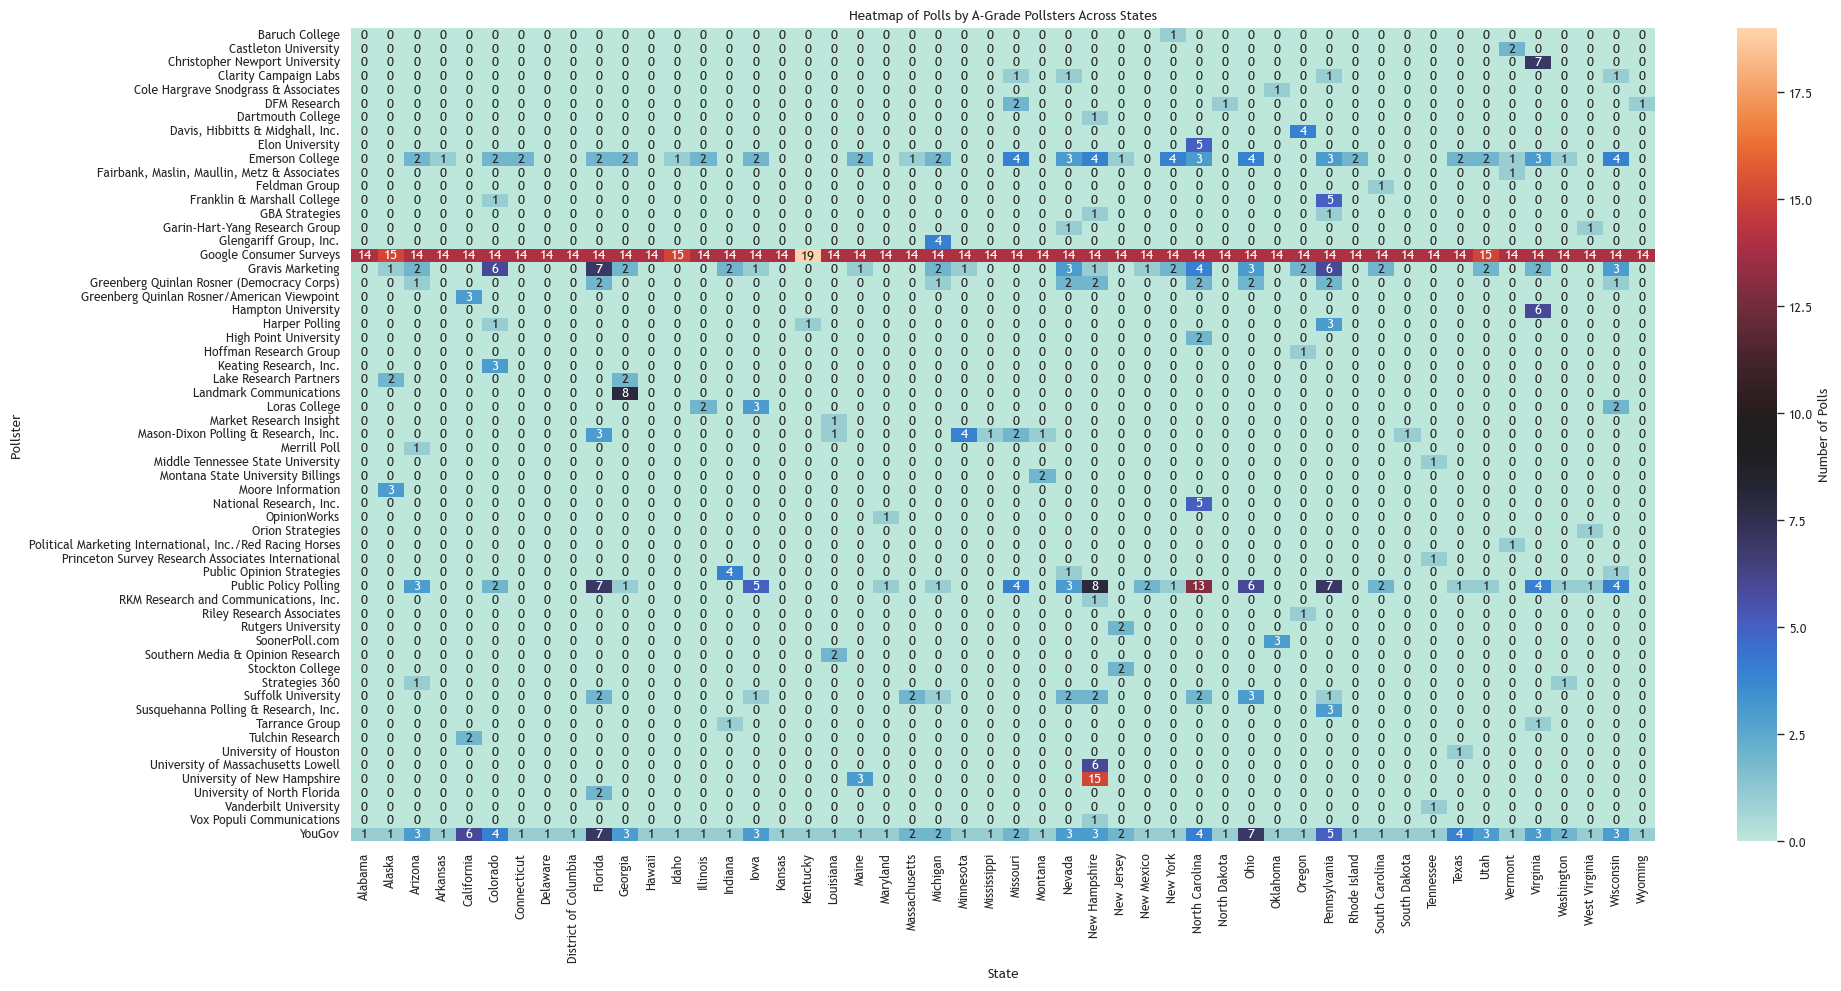

In [12]:
# Pivot the data to create a matrix with pollsters as rows and states as columns
pollster_state_pivot = b_pollster_state_count.pivot(index='pollster', columns='state', values='poll_count').fillna(0)

# Create the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(pollster_state_pivot, cmap='icefire', annot=True, fmt='g', cbar_kws={'label': 'Number of Polls'})

plt.title('Heatmap of Polls by A-Grade Pollsters Across States')
plt.xlabel('State')
plt.ylabel('Pollster')
plt.tight_layout()

plt.show()

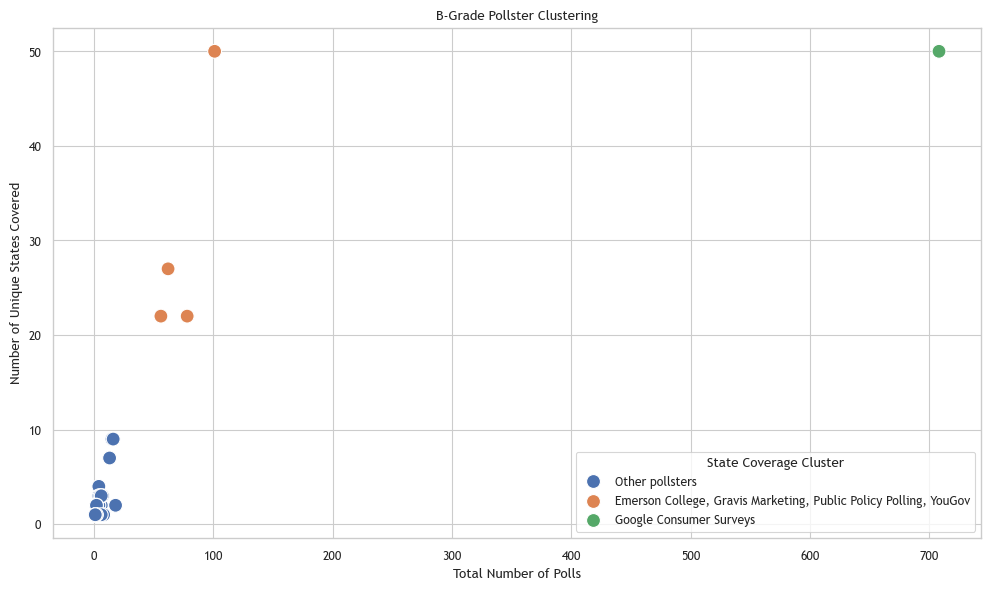

In [13]:
# Calculate the total number of polls and the number of unique states for each pollster
b_pollster_stats = b_pollster_state_count.groupby('pollster').agg(
    total_polls=('poll_count', 'sum'),
    unique_states=('state', 'nunique')
).reset_index()

# Pivot the data to create a matrix with pollsters as rows and states as columns
b_pollster_state_pivot = b_pollster_state_count.pivot(index='pollster', columns='state', values='poll_count').fillna(0)

# Apply clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
b_pollster_state_pivot['cluster'] = kmeans.fit_predict(b_pollster_state_pivot)

# Add cluster labels to the pollster stats dataframe
b_pollster_stats['cluster'] = b_pollster_state_pivot['cluster'].values

# Instead of numbers let's put some names of the clusters
b_cluster_counts = b_pollster_state_pivot['cluster'].value_counts().sort_values()
b_cluster_sorted = b_cluster_counts.index.to_list()

b_pollster_stats['cluster_name'] = 'Other pollsters'

b_pollsters_cluster_1 = b_pollster_stats[b_pollster_stats['cluster'] == b_cluster_sorted[0]]['pollster']
b_pollsters_cluster_1_name = ', '.join(b_pollsters_cluster_1.values)
b_pollster_stats.loc[b_pollster_stats['cluster'] == b_cluster_sorted[0], 'cluster_name'] = b_pollsters_cluster_1_name

b_pollsters_cluster_2 = b_pollster_stats[b_pollster_stats['cluster'] == b_cluster_sorted[1]]['pollster']
b_pollsters_cluster_2_name = ', '.join(b_pollsters_cluster_2.values)
b_pollster_stats.loc[b_pollster_stats['cluster'] == b_cluster_sorted[1], 'cluster_name'] = b_pollsters_cluster_2_name


# Recreate the scatter plot focusing only on state coverage clusters and total polls
plt.figure(figsize=(10, 6))
sns.scatterplot(data=b_pollster_stats, x='total_polls', y='unique_states', hue='cluster_name', palette='deep', s=100)

plt.title('B-Grade Pollster Clustering')
plt.xlabel('Total Number of Polls')
plt.ylabel('Number of Unique States Covered')
plt.legend(title='State Coverage Cluster')
plt.tight_layout()

plt.show()

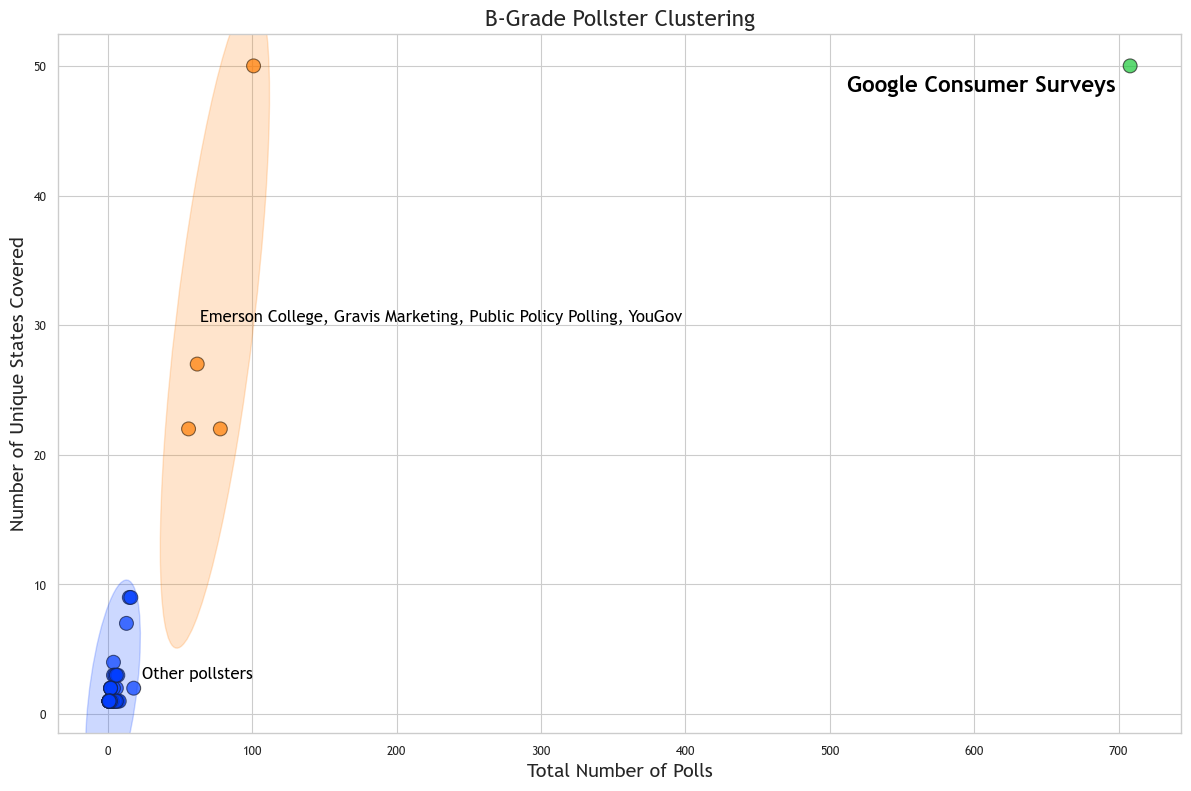

In [14]:
unique_cluster_names = b_pollster_stats['cluster_name'].unique()
palette = sns.color_palette(PALETTE, len(unique_cluster_names))

# Map each cluster name to a color
color_mapping = dict(zip(unique_cluster_names, palette))

plt.figure(figsize=(12, 8))
ax = plt.gca()

sns.scatterplot(
    data=b_pollster_stats,
    x='total_polls',
    y='unique_states',
    hue='cluster_name',
    palette=color_mapping,
    s=100,
    edgecolor='k',
    alpha=0.7
)

plt.legend().remove()

# Calculate centroids for each cluster
centroids = b_pollster_stats.groupby('cluster_name')[['total_polls', 'unique_states']].mean().reset_index()

# Annotate each cluster with its name
plt.text(
    centroids.iloc[0]['total_polls'] - 10,
    centroids.iloc[0]['unique_states'],
    centroids.iloc[0]['cluster_name'],
    fontsize=12,
    fontweight='400',
    color='black',
)
plt.text(
    centroids.iloc[1]['total_polls'] - 10,
    centroids.iloc[1]['unique_states'] - 2,
    centroids.iloc[1]['cluster_name'],
    fontsize=16,
    fontweight='bold',
    color='black',
    horizontalalignment='right',
)
plt.text(
    centroids.iloc[2]['total_polls'] + 20,
    centroids.iloc[2]['unique_states'] + 1,
    centroids.iloc[2]['cluster_name'],
    fontsize=12,
    fontweight='200',
    color='black',
    horizontalalignment='left',
)

# Draw confidence ellipses for each cluster
confidence_level = 0.95
n_std = 4.5

for cluster_name, color in color_mapping.items():
    cluster_data = b_pollster_stats[b_pollster_stats['cluster_name'] == cluster_name]
    if cluster_data.shape[0] < 2:
        # in case we don't have enough points to plot an ellipse
        continue
    confidence_ellipse(
        cluster_data['total_polls'],
        cluster_data['unique_states'],
        ax,
        n_std=n_std,
        facecolor=color,
        edgecolor=color,
        linewidth=1,
        alpha=0.2
    )
    n_std *= 0.4  # not the best approach but i want the cluster with the other pollsters to have bigger area

plt.title('B-Grade Pollster Clustering', fontsize=16)
plt.xlabel('Total Number of Polls', fontsize=14)
plt.ylabel('Number of Unique States Covered', fontsize=14)
plt.tight_layout()
plt.savefig('pollster_b_grade_clustering.png', dpi=300)

## C-Grade

In [15]:
ds_states = ds[ds['state'] != 'U.S.']
ds_states = ds_states[~ds_states['state'].isin(['Nebraska', 'Nebraska CD-1', 'Nebraska CD-2', 'Nebraska CD-3', 'Maine CD-1', 'Maine CD-2'])]
c_grade_pollsters = ds_states[ds_states['grade'].isin(['C+', 'C', 'C-'])]

# Group by pollster and state to get the count of polls conducted
c_pollster_state_count = c_grade_pollsters.groupby(['pollster', 'state']).size().reset_index(name='poll_count')

c_unique_pollsters = c_grade_pollsters['pollster'].unique()

c_pollster_state_count

,pollster,state,poll_count
0,American Research Group,New Hampshire,3
1,Anzalone Liszt Grove Research,Louisiana,1
2,Anzalone Liszt Grove Research,Ohio,1
3,Arizona State University,Arizona,2
4,Basswood Research,Illinois,1
...,...,...,...
120,We Ask America,Illinois,2
121,Western Kentucky University,Kentucky,1
122,Y2 Analytics,Utah,2
123,Zogby Interactive/JZ Analytics,Kansas,1


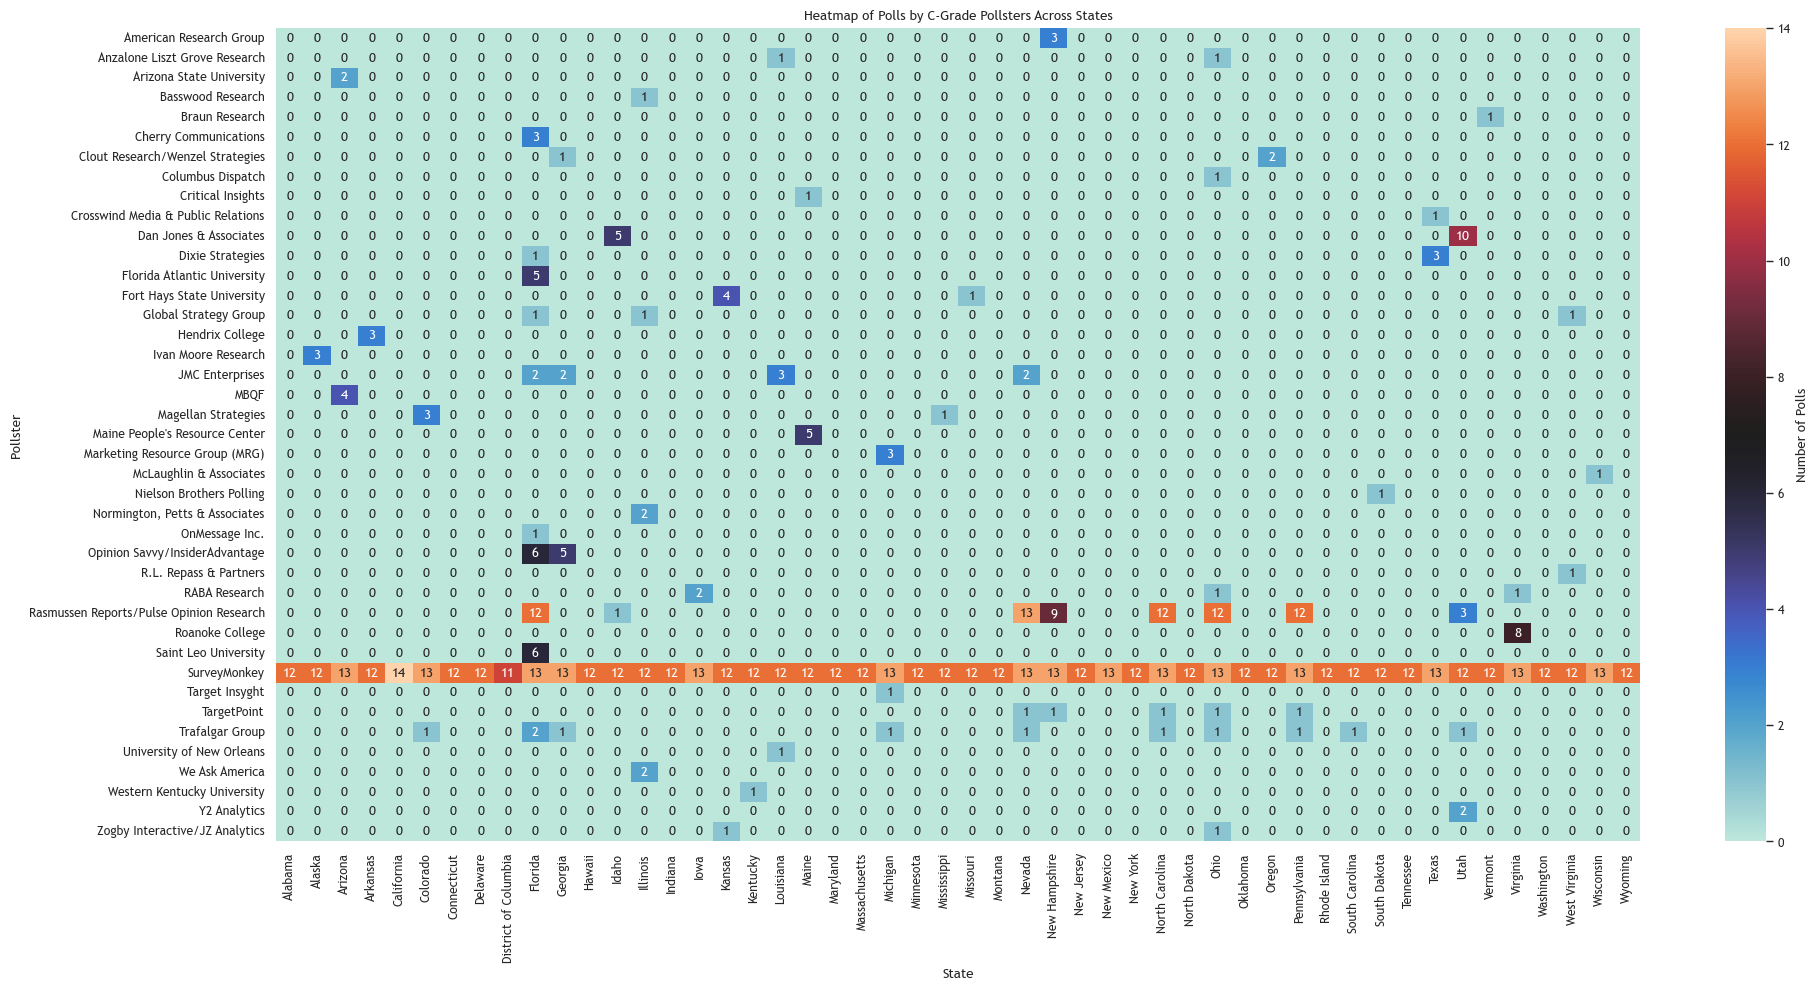

In [16]:
c_pollster_state_pivot = c_pollster_state_count.pivot(index='pollster', columns='state', values='poll_count').fillna(0)

plt.figure(figsize=(20, 10))
sns.heatmap(c_pollster_state_pivot, cmap='icefire', annot=True, fmt='g', cbar_kws={'label': 'Number of Polls'})

plt.title('Heatmap of Polls by C-Grade Pollsters Across States')
plt.xlabel('State')
plt.ylabel('Pollster')
plt.tight_layout()

plt.show()

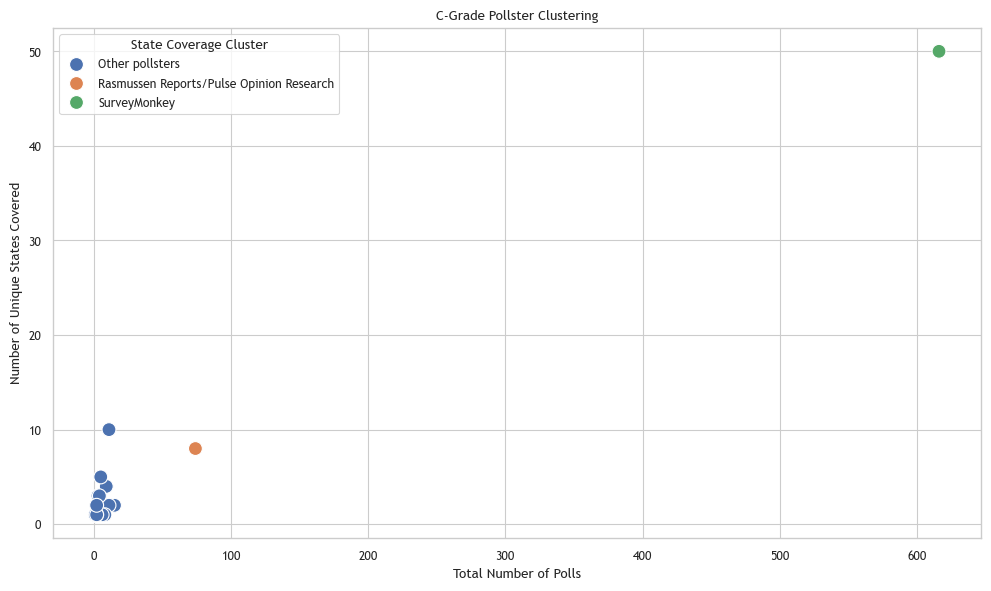

In [17]:
# Calculate the total number of polls and the number of unique states for each pollster
c_pollster_stats = c_pollster_state_count.groupby('pollster').agg(
    total_polls=('poll_count', 'sum'),
    unique_states=('state', 'nunique')
).reset_index()

# Pivot the data to create a matrix with pollsters as rows and states as columns
c_pollster_state_pivot = c_pollster_state_count.pivot(index='pollster', columns='state', values='poll_count').fillna(0)

# Apply clustering
n_clusters = 3
cl = Birch(threshold=1.785, n_clusters=n_clusters)
c_pollster_state_pivot['cluster'] = cl.fit_predict(c_pollster_state_pivot)

# Add cluster labels to the pollster stats dataframe
c_pollster_stats['cluster'] = c_pollster_state_pivot['cluster'].values

# Instead of numbers let's put some names of the clusters
c_cluster_counts = c_pollster_state_pivot['cluster'].value_counts().sort_values()
c_cluster_sorted = c_cluster_counts.index.to_list()

c_pollster_stats['cluster_name'] = 'Other pollsters'

c_pollsters_cluster_1 = c_pollster_stats[c_pollster_stats['cluster'] == c_cluster_sorted[0]]['pollster']
c_pollsters_cluster_1_name = ', '.join(c_pollsters_cluster_1.values)
c_pollster_stats.loc[c_pollster_stats['cluster'] == c_cluster_sorted[0], 'cluster_name'] = c_pollsters_cluster_1_name

c_pollsters_cluster_2 = c_pollster_stats[c_pollster_stats['cluster'] == c_cluster_sorted[1]]['pollster']
c_pollsters_cluster_2_name = ', '.join(c_pollsters_cluster_2.values)
c_pollster_stats.loc[c_pollster_stats['cluster'] == c_cluster_sorted[1], 'cluster_name'] = c_pollsters_cluster_2_name


# Recreate the scatter plot focusing only on state coverage clusters and total polls
plt.figure(figsize=(10, 6))
sns.scatterplot(data=c_pollster_stats, x='total_polls', y='unique_states', hue='cluster_name', palette='deep', s=100)

plt.title('C-Grade Pollster Clustering')
plt.xlabel('Total Number of Polls')
plt.ylabel('Number of Unique States Covered')
plt.legend(title='State Coverage Cluster')
plt.tight_layout()

plt.show()

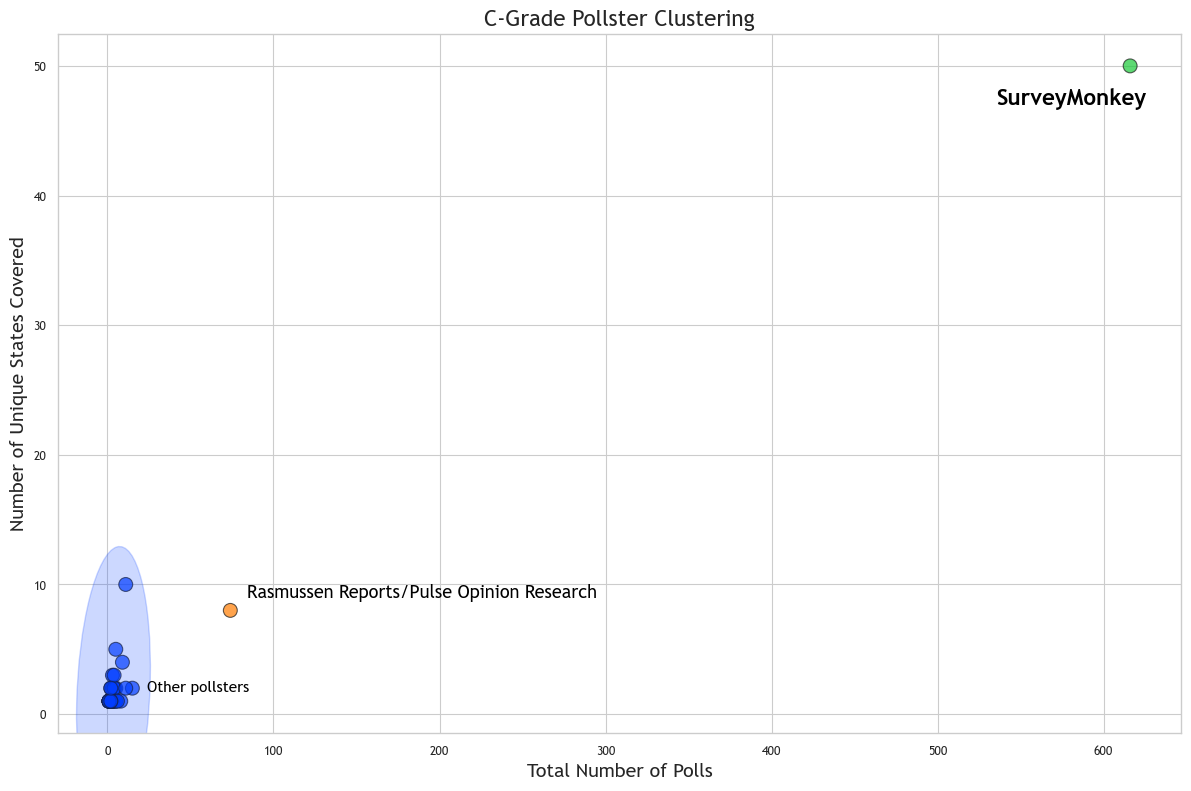

In [18]:
unique_cluster_names = c_pollster_stats['cluster_name'].unique()
palette = sns.color_palette(PALETTE, len(unique_cluster_names))

# Map each cluster name to a color
color_mapping = dict(zip(unique_cluster_names, palette))

plt.figure(figsize=(12, 8))
ax = plt.gca()

sns.scatterplot(
    data=c_pollster_stats,
    x='total_polls',
    y='unique_states',
    hue='cluster_name',
    palette=color_mapping,
    s=100,
    edgecolor='k',
    alpha=0.7
)

plt.legend().remove()

# Calculate centroids for each cluster
centroids = c_pollster_stats.groupby('cluster_name')[['total_polls', 'unique_states']].mean().reset_index()

# Annotate each cluster with its name
plt.text(
    centroids.iloc[0]['total_polls'] + 20,
    centroids.iloc[0]['unique_states'],
    centroids.iloc[0]['cluster_name'],
    fontsize=11,
    fontweight='200',
    color='black',
    horizontalalignment='left',
)
plt.text(
    centroids.iloc[1]['total_polls'] + 10,
    centroids.iloc[1]['unique_states'] + 1,
    centroids.iloc[1]['cluster_name'],
    fontsize=13,
    fontweight='500',
    color='black',
    horizontalalignment='left',
)
plt.text(
    centroids.iloc[2]['total_polls'] + 10,
    centroids.iloc[2]['unique_states'] - 3,
    centroids.iloc[2]['cluster_name'],
    fontsize=16,
    fontweight='bold',
    color='black',
    horizontalalignment='right',
)

# Draw confidence ellipses for each cluster
confidence_level = 0.95
n_std = 6

for cluster_name, color in color_mapping.items():
    cluster_data = c_pollster_stats[c_pollster_stats['cluster_name'] == cluster_name]
    if cluster_data.shape[0] < 2:
        # in case we don't have enough points to plot an ellipse
        continue
    confidence_ellipse(
        cluster_data['total_polls'],
        cluster_data['unique_states'],
        ax,
        n_std=n_std,
        facecolor=color,
        edgecolor=color,
        linewidth=1,
        alpha=0.2
    )
    n_std *= 0.4  # not the best approach but i want the cluster with the other pollsters to have bigger area

# Enhance the plot
plt.title('C-Grade Pollster Clustering', fontsize=16)
plt.xlabel('Total Number of Polls', fontsize=14)
plt.ylabel('Number of Unique States Covered', fontsize=14)
# plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.show()
plt.savefig('pollster_c_grade_clustering.png', dpi=300)

# Trends

# A-Grade clusters

In [31]:
# Convert dates to datetime format for proper time-series handling
ds['startdate'] = pd.to_datetime(ds['startdate'])
ds['enddate'] = pd.to_datetime(ds['enddate'])

# Filter relevant columns
# poll_data = ds[['pollster', 'startdate', 'enddate', 'grade', 'adjpoll_clinton', 'adjpoll_trump', 'adjpoll_johnson', 'adjpoll_mcmullin']].dropna()
poll_data = ds[['pollster', 'startdate', 'enddate', 'grade', 'adjpoll_clinton', 'adjpoll_trump']].dropna()

# Melt the data to have candidates in one column
poll_data_melted = poll_data.melt(id_vars=['startdate', 'enddate', 'pollster', 'grade'], 
                                  value_vars=['adjpoll_clinton', 'adjpoll_trump'],
                                #   value_vars=['adjpoll_clinton', 'adjpoll_trump', 'adjpoll_johnson', 'adjpoll_mcmullin'],
                                  var_name='candidate', 
                                  value_name='adjusted_poll')

# Replace candidate names for readability
poll_data_melted['candidate'] = poll_data_melted['candidate'].replace({
    'adjpoll_clinton': 'Clinton', 
    'adjpoll_trump': 'Trump', 
    # 'adjpoll_johnson': 'Johnson', 
    # 'adjpoll_mcmullin': 'McMullin'
})

In [41]:
poll_data_a_cluster1 = poll_data[poll_data['pollster'].isin(a_pollsters_cluster_1.values)]
poll_data_a_cluster2 = poll_data[poll_data['pollster'].isin(a_pollsters_cluster_2.values)]

In [42]:
poll_data_a_cluster1_melted = poll_data_a_cluster1.melt(id_vars=['startdate', 'enddate', 'pollster'], 
                                  value_vars=['adjpoll_clinton', 'adjpoll_trump'],
                                  var_name='candidate', 
                                  value_name='adjusted_poll')

poll_data_a_cluster2_melted = poll_data_a_cluster2.melt(id_vars=['startdate', 'enddate', 'pollster'], 
                                  value_vars=['adjpoll_clinton', 'adjpoll_trump'],
                                  var_name='candidate', 
                                  value_name='adjusted_poll')

poll_data_a_cluster2_melted['candidate'] = poll_data_a_cluster2_melted['candidate'].replace({
    'adjpoll_clinton': 'Clinton',
    'adjpoll_trump': 'Trump', 
})

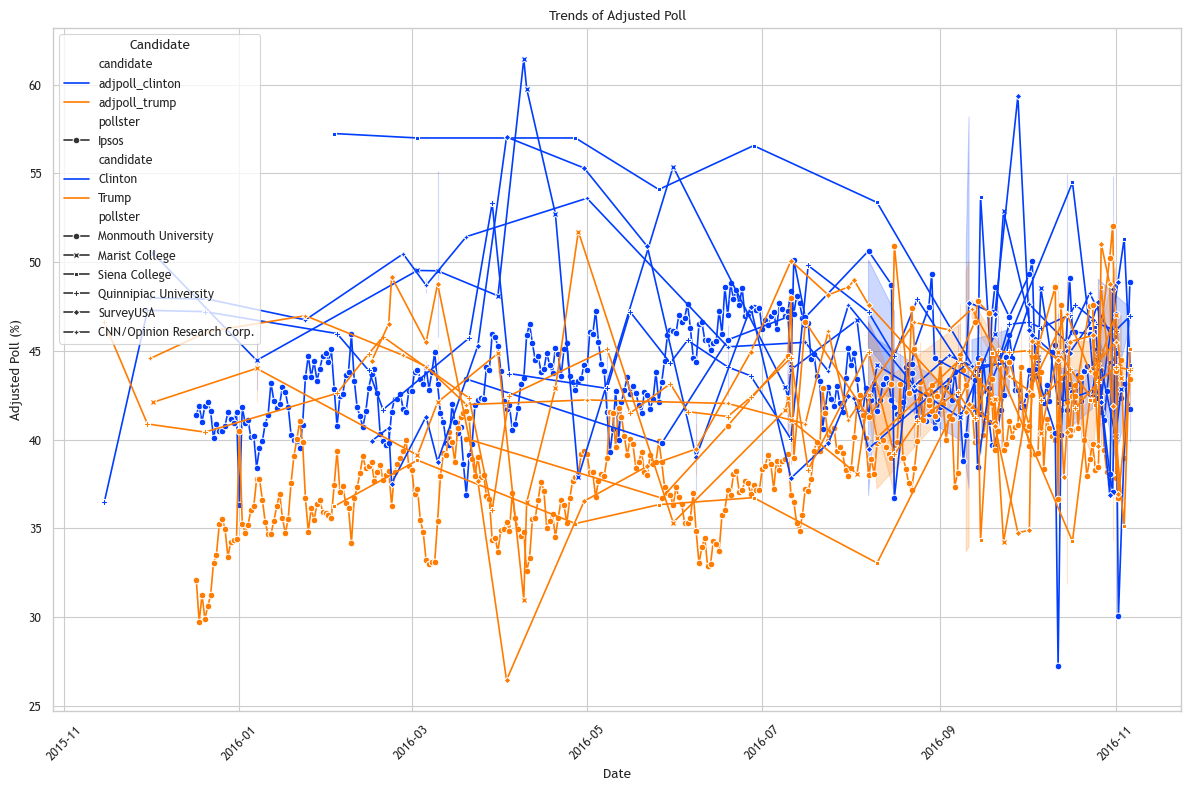

In [43]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=poll_data_a_cluster1_melted, x='enddate', y='adjusted_poll', hue='candidate', style='pollster', markers=True, dashes=False)
sns.lineplot(data=poll_data_a_cluster2_melted, x='enddate', y='adjusted_poll', hue='candidate', style='pollster', markers=True, dashes=False)

plt.title('Trends of Adjusted Poll')
plt.xlabel('Date')
plt.ylabel('Adjusted Poll (%)')
plt.xticks(rotation=45)
plt.legend(title='Candidate')
plt.tight_layout()
plt.show()


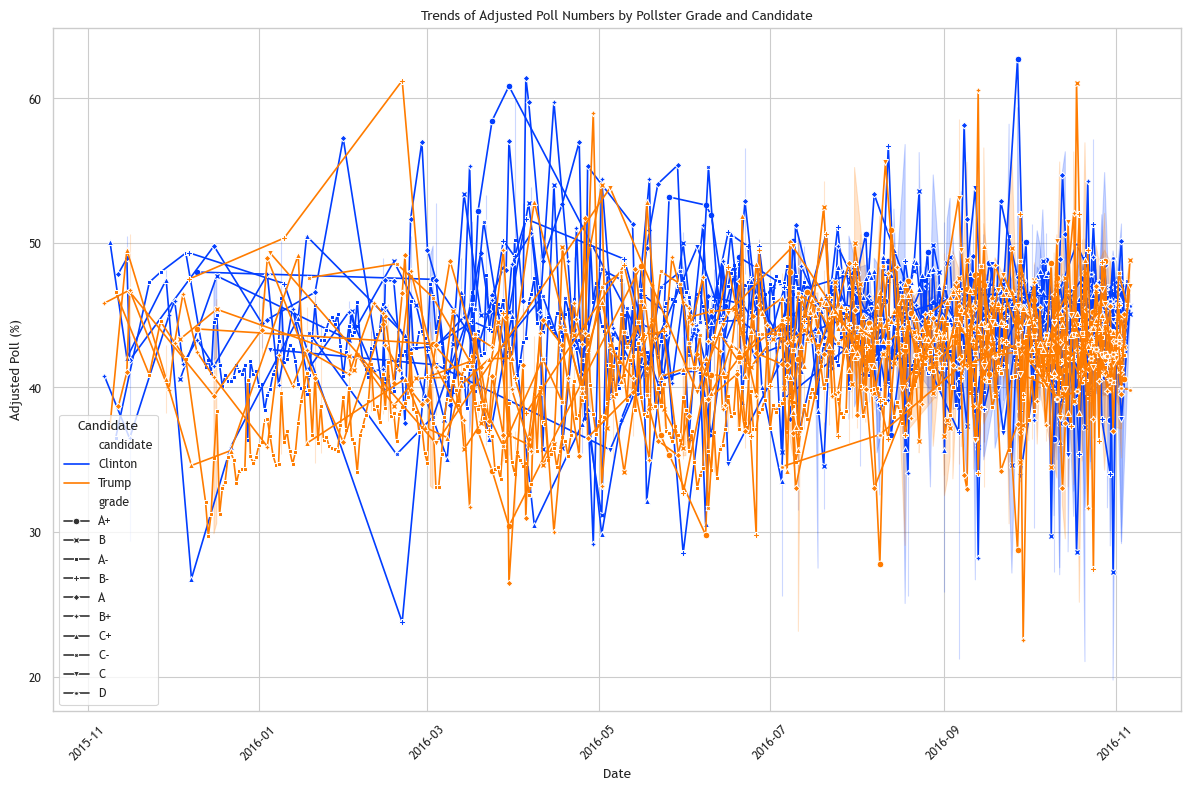

In [19]:
# Create the line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=poll_data_melted, x='startdate', y='adjusted_poll', hue='candidate', style='grade', markers=True, dashes=False)

plt.title('Trends of Adjusted Poll Numbers by Pollster Grade and Candidate')
plt.xlabel('Date')
plt.ylabel('Adjusted Poll (%)')
plt.xticks(rotation=45)
plt.legend(title='Candidate')
plt.tight_layout()
plt.show()


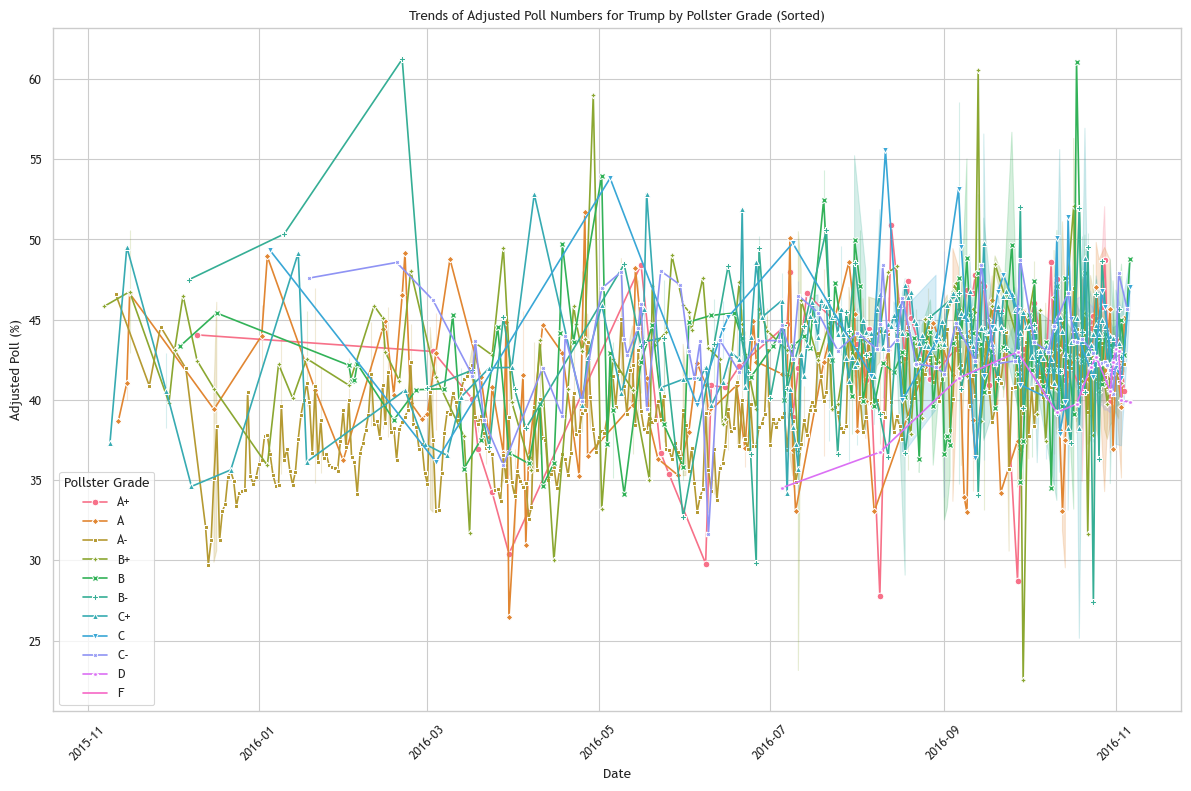

In [20]:
# Filter the data for only Trump
trump_data = poll_data_melted[poll_data_melted['candidate'] == 'Trump']

# Define a custom order for the pollster grades
grade_order = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D', 'F']

# Create the line plot for Trump with custom sorted grades
plt.figure(figsize=(12, 8))
sns.lineplot(data=trump_data, x='startdate', y='adjusted_poll', style='grade', markers=True, dashes=False, 
             hue='grade', hue_order=grade_order)

plt.title('Trends of Adjusted Poll Numbers for Trump by Pollster Grade (Sorted)')
plt.xlabel('Date')
plt.ylabel('Adjusted Poll (%)')
plt.xticks(rotation=45)
plt.legend(title='Pollster Grade')
plt.tight_layout()

# Show the plot
plt.show()


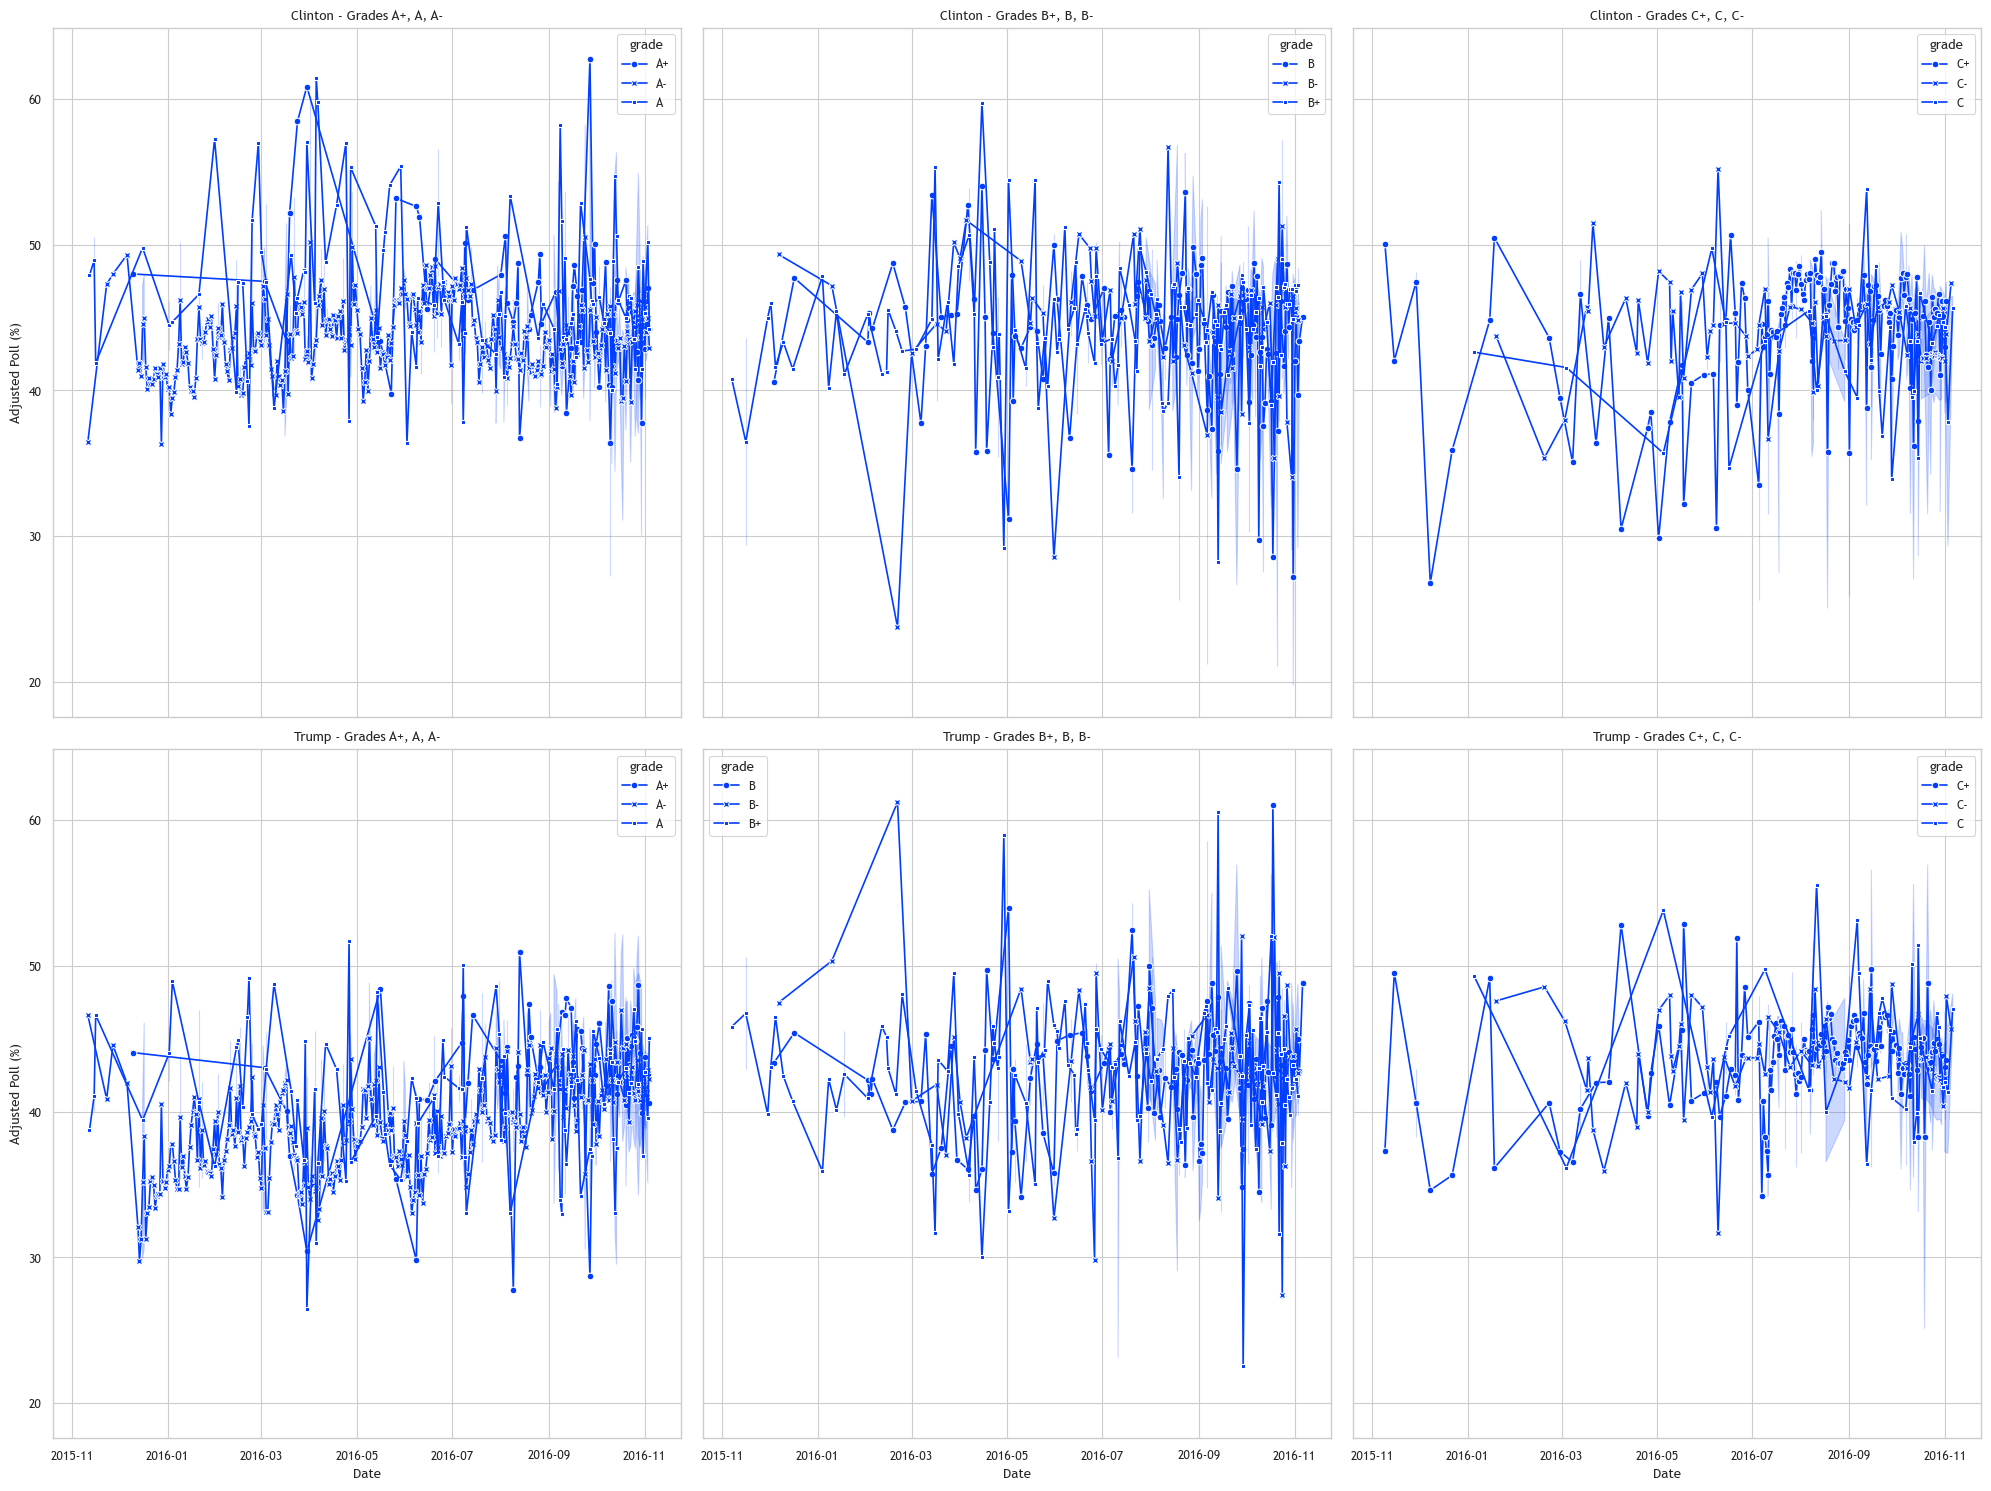

In [21]:
# Filter data for grades starting with 'A', 'B', 'C', 'D'
filtered_grades = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D']

# Prepare data for subplots, focus on Trump for now, but create a structure for multiple candidates
candidates = ['Clinton', 'Trump']
# candidates = ['Clinton', 'Trump', 'Johnson', 'McMullin']
poll_data_filtered = poll_data_melted[poll_data_melted['grade'].isin(filtered_grades)]

# Define subplot grid, 4 candidates (rows) by 4 grade groups (columns)
fig, axes = plt.subplots(len(candidates), 3, figsize=(20, 15), sharex=True, sharey=True)

# Grade groups to visualize
grade_groups = [['A+', 'A', 'A-'], ['B+', 'B', 'B-'], ['C+', 'C', 'C-']]

# Plot each candidate and their grade groups
for i, candidate in enumerate(candidates):
    candidate_data = poll_data_filtered[poll_data_filtered['candidate'] == candidate]
    for j, grade_group in enumerate(grade_groups):
        grade_data = candidate_data[candidate_data['grade'].isin(grade_group)]
        sns.lineplot(ax=axes[i, j], data=grade_data, x='startdate', y='adjusted_poll', style='grade', markers=True, dashes=False)
        axes[i, j].set_title(f"{candidate} - Grades {', '.join(grade_group)}")
        if i == len(candidates) - 1:
            axes[i, j].set_xlabel('Date')
        if j == 0:
            axes[i, j].set_ylabel('Adjusted Poll (%)')

plt.tight_layout()
plt.show()


# Comparison of Pollster Accuracy

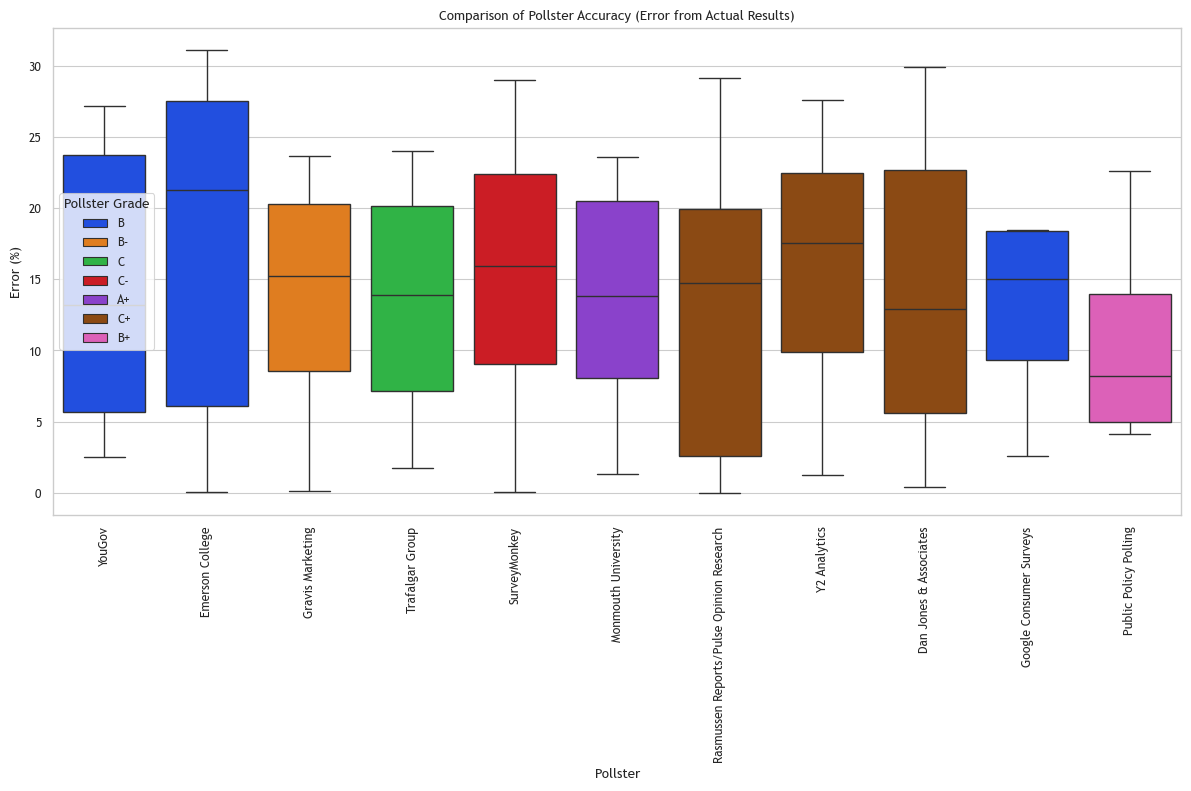

In [22]:

# Filter relevant columns for adjusted poll numbers and dates
poll_data = ds[['startdate', 'pollster', 'grade', 'adjpoll_clinton', 'adjpoll_trump', 'adjpoll_johnson', 'adjpoll_mcmullin']].dropna()

# Melt the data to have candidates in one column
poll_data_melted = poll_data.melt(id_vars=['startdate', 'pollster', 'grade'], 
                                  value_vars=['adjpoll_clinton', 'adjpoll_trump', 'adjpoll_johnson', 'adjpoll_mcmullin'],
                                  var_name='candidate', 
                                  value_name='adjusted_poll')

# Replace candidate names for readability
poll_data_melted['candidate'] = poll_data_melted['candidate'].replace({
    'adjpoll_clinton': 'Clinton', 
    'adjpoll_trump': 'Trump', 
    'adjpoll_johnson': 'Johnson', 
    'adjpoll_mcmullin': 'McMullin'
})

# Assuming the actual results for candidates:
actual_results = {'Clinton': 48.2, 'Trump': 46.1, 'Johnson': 3.3, 'McMullin': 0.5}

# Calculate the absolute error for each pollster's adjusted poll figures compared to actual results
poll_data_melted['actual_result'] = poll_data_melted['candidate'].map(actual_results)
poll_data_melted['error'] = abs(poll_data_melted['adjusted_poll'] - poll_data_melted['actual_result'])

# Filter out pollsters with missing values
pollster_error_data = poll_data_melted[['pollster', 'grade', 'error']].dropna()

# Create a boxplot showing the distribution of errors for each pollster, colored by grade
plt.figure(figsize=(12, 8))
sns.boxplot(data=pollster_error_data, x='pollster', y='error', hue='grade')

plt.title('Comparison of Pollster Accuracy (Error from Actual Results)')
plt.xlabel('Pollster')
plt.ylabel('Error (%)')
plt.xticks(rotation=90)
plt.legend(title='Pollster Grade')
plt.tight_layout()

plt.show()


In [80]:
poll_data = ds[['state', 'pollster', 'startdate', 'enddate', 'grade', 'adjpoll_clinton', 'adjpoll_trump']].dropna()

In [81]:
swing_states_results = {
    'Florida': {'Clinton': 47.8, 'Trump': 49.1},
    'Pennsylvania': {'Clinton': 47.6, 'Trump': 48.8},
    'Michigan': {'Clinton': 47.3, 'Trump': 47.6},
    'Wisconsin': {'Clinton': 46.9, 'Trump': 47.9},
    'Ohio': {'Clinton': 43.5, 'Trump': 52.1},
    'North Carolina': {'Clinton': 46.7, 'Trump': 50.5},
    'Arizona': {'Clinton': 45.4, 'Trump': 49.5},
    'Nevada': {'Clinton': 47.9, 'Trump': 45.5},
    'New Hampshire': {'Clinton': 47.6, 'Trump': 47.2},
    'Virginia': {'Clinton': 49.9, 'Trump': 45.0},
}

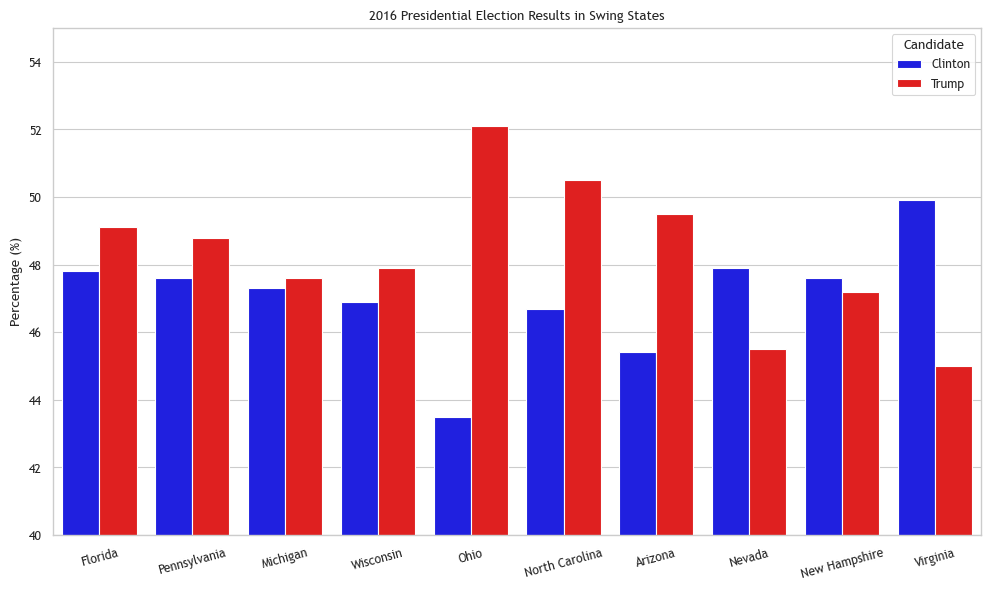

In [95]:
swing_states_results_df = pd.DataFrame(swing_states_results).T.reset_index()
swing_states_results_df = swing_states_results_df.melt(id_vars='index', var_name='Candidate', value_name='Result')
swing_states_results_df = swing_states_results_df.rename(columns={'index': 'State'})

plt.figure(figsize=(10, 6))

sstate_res_bar = sns.barplot(data=swing_states_results_df, x='State', y='Result', hue='Candidate', 
            palette={'Clinton': 'blue', 'Trump': 'red'})
sstate_res_bar.set(xlabel=None)

plt.title('2016 Presidential Election Results in Swing States')
# plt.xlabel('State')
plt.ylabel('Percentage (%)')
plt.ylim(40, 55)
plt.xticks(rotation=15)
plt.tight_layout()

plt.savefig('swing_states_results.png', dpi=150)


In [82]:
# cluster_pollsters = ['CNN/Opinion Research Corp.', 'Marist College', 'Monmouth University', 'Quinnipiac University', 'Siena College', 'SurveyUSA']
cluster_polls = poll_data[
    (poll_data['pollster'].isin(a_pollsters_cluster_1.values)) & (poll_data['state'].isin(swing_states_results.keys()))
    ]

cluster_polls['clinton_error'] = abs(cluster_polls['adjpoll_clinton'] - cluster_polls['state'].map(lambda x: swing_states_results[x]['Clinton']))
cluster_polls['trump_error'] = abs(cluster_polls['adjpoll_trump'] - cluster_polls['state'].map(lambda x: swing_states_results[x]['Trump']))

a_cluster1_accuracy_by_state = cluster_polls.groupby('state')[['clinton_error', 'trump_error']].mean().reset_index()
# a_cluster1_accuracy_by_state.rename(columns={
#     'clinton_error': 'Clinton',
#     'trump_error': 'Trump',
# })

/var/folders/28/l2lfqs811tv1tcy8vm_ls2140000gn/T/ipykernel_52350/4078052480.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_polls['clinton_error'] = abs(cluster_polls['adjpoll_clinton'] - cluster_polls['state'].map(lambda x: swing_states_results[x]['Clinton']))
/var/folders/28/l2lfqs811tv1tcy8vm_ls2140000gn/T/ipykernel_52350/4078052480.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_polls['trump_error'] = abs(cluster_polls['adjpoll_trump'] - cluster_polls['state'].map(lambda x: swing

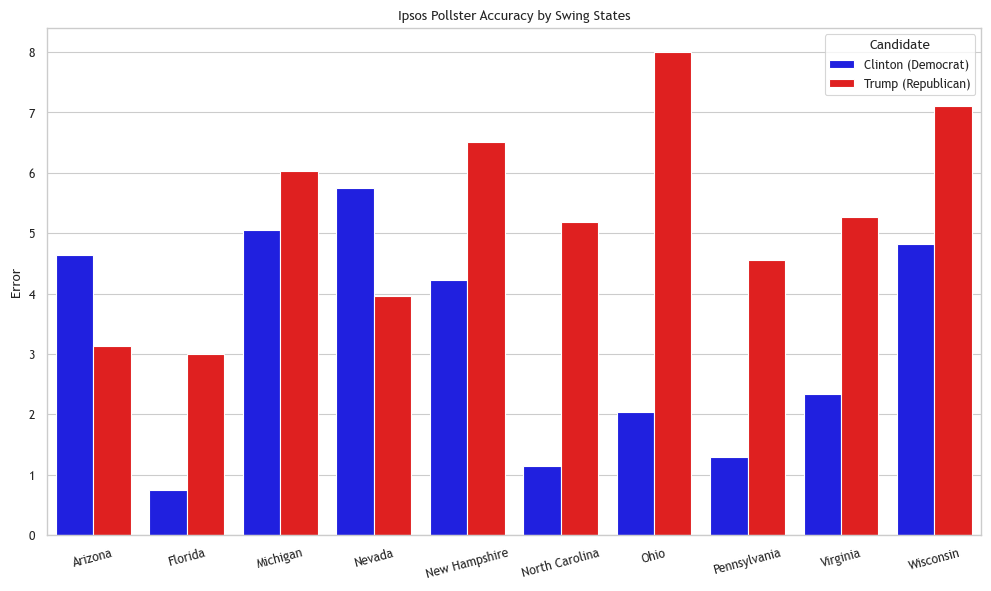

In [85]:

plt.figure(figsize=(10, 6))

# Modify the column names for proper labeling in the melt
a_cluster1_accuracy_by_state = a_cluster1_accuracy_by_state.rename(columns={
    'clinton_error': 'Clinton (Democrat)',
    'trump_error': 'Trump (Republican)'
    })

# Create the bar plot with blue and red colors
a1_bar = sns.barplot(data=a_cluster1_accuracy_by_state.melt(id_vars='state', var_name='Candidate', value_name='Error'),
            x='state', y='Error', hue='Candidate', palette={'Clinton (Democrat)': 'blue', 'Trump (Republican)': 'red'})

a1_bar.set(xlabel=None)
plt.title('Ipsos Pollster Accuracy by Swing States')
plt.xticks(rotation=15)
plt.tight_layout()

plt.show()


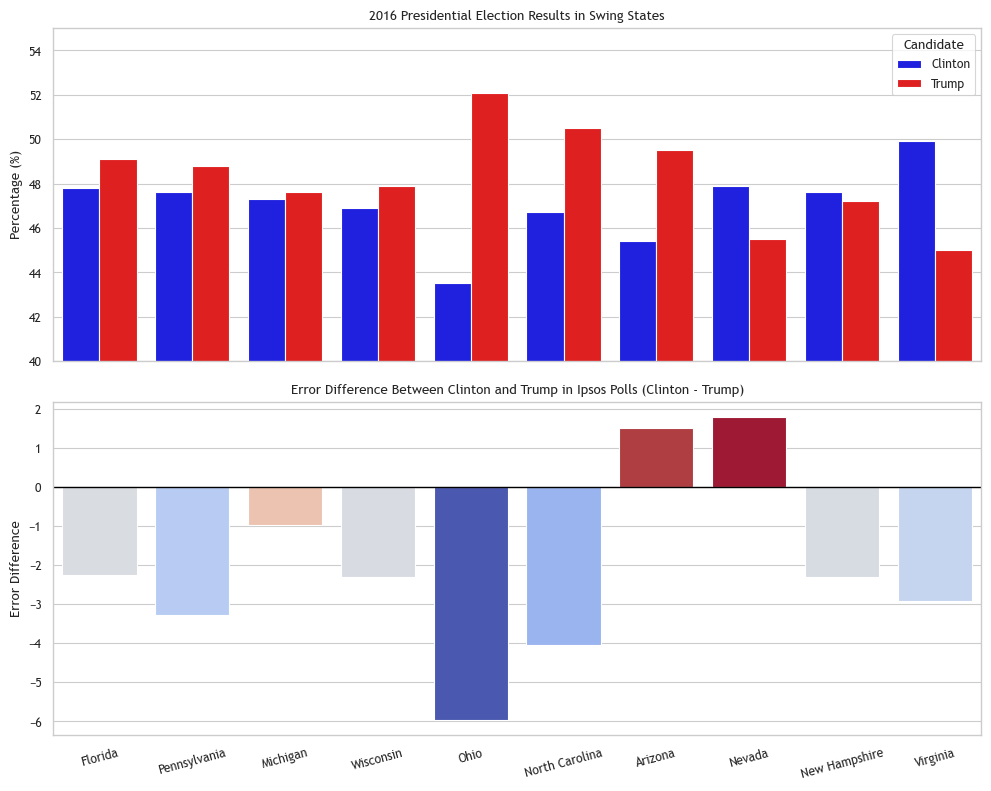

In [94]:
a_cluster1_accuracy_by_state['error_difference'] = a_cluster1_accuracy_by_state['Clinton (Democrat)'] - a_cluster1_accuracy_by_state['Trump (Republican)']
ac1_error_difference_by_state = a_cluster1_accuracy_by_state.groupby('state')['error_difference'].mean().reset_index()

# Set up a figure with two stacked plots: the election results and error difference
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

sns.barplot(data=swing_states_results_df, x='State', y='Result', hue='Candidate', 
            palette={'Clinton': 'blue', 'Trump': 'red'}, ax=axes[0])
axes[0].set_title('2016 Presidential Election Results in Swing States')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_ylim(40, 55)
axes[0].legend(title='Candidate')

acerro_bar = sns.barplot(data=ac1_error_difference_by_state, x='state', y='error_difference', hue='error_difference', palette='coolwarm',
                         ax=axes[1], legend=False)
axes[1].set_title('Error Difference Between Clinton and Trump in Ipsos Polls (Clinton - Trump)')
axes[1].set_ylabel('Error Difference')
axes[1].axhline(0, color='black', linewidth=1)
# axes[1].set_xlabel('State')
axes[1].tick_params(axis='x', rotation=15)
acerro_bar.set(xlabel=None)

plt.tight_layout()
# plt.show()
plt.savefig('swing_states_results_with_errors.png', dpi=150)